In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
np.random.seed(59)
sns.set_theme(style="ticks", context="poster", font_scale=1.4)


from conformal_tree import ConformalTreeRegression
from demo_util import gen_sin_data, split_conformal

# Example data

We demonstrate conformal tree on a univariate regression task with heteroscedastic noise. 

We generate i.i.d. data and split into a training, calibration, and test set.

We show a scatter plot of test data below.

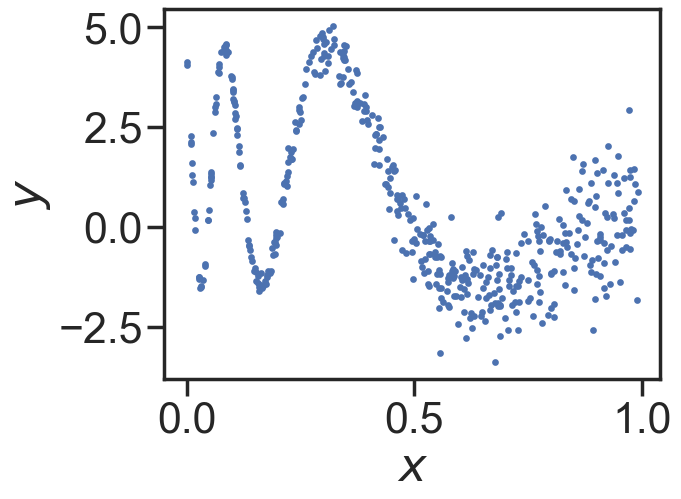

In [2]:
X_train1, y_train1, X_calib1, y_calib1, X_test1, y_test1 = gen_sin_data(data=1, n_train=1000, n_calib=500, n_test=500)


xord1 = np.argsort(X_test1.flatten())
plt.scatter(X_test1.flatten()[xord1], y_test1[xord1], s=8)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In this demonstration, we use a simple neural network (a multilayer perceptron) to predict the conditional mean of $y$ given $x$.

This model is fit on the training data.

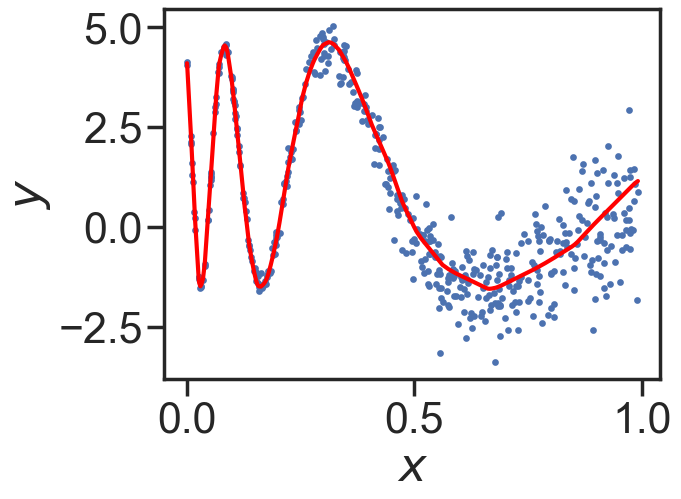

In [3]:
model1 = MLPRegressor(hidden_layer_sizes=(256,256,256,256,256), max_iter=1200)
model1.fit(X_train1, y_train1)
y_calib_pred1 = model1.predict(X_calib1)
y_test_pred1 = model1.predict(X_test1)

plt.scatter(X_test1.flatten()[xord1], y_test1[xord1], s=8)
plt.plot(X_test1.flatten()[xord1], y_test_pred1[xord1], lw=3, color="red")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

Next, we obtain prediction intervals using conformal tree. 

We do this by creating an instance of the `ConformalTreeRegression` class. The domain must be specified, and tree regularization hyperparameters can be specified, such as the minimum number of samples per leaf, the maximum number of leaves, or the minimum improvement threshold required for splitting.

The `calibrate` method takes the calibration data and conformity scores as arguments, along with the desired confidence level. As this is a regression task, we use the absolute error as our conformity scores in this example. The `calibrate` method fits a robust dyadic tree to estimate the conformity scores in the covariate space, giving us a way to model the conformity scores that is robust to the missingness of the test point. It also computes the width of the $1-\alpha$ interval within each leaf of the tree.

The `test_set` method takes in an array of new test points, and the model's predictions, and returns a pair of arrays containing the lower and upper bounds for each test point, according the leaf nodes in the tree in which each test point lies.


We plot the resulting prediction sets alongside the corresponding ones yielded by standard split conformal prediction below, as well as some aggregate metrics.


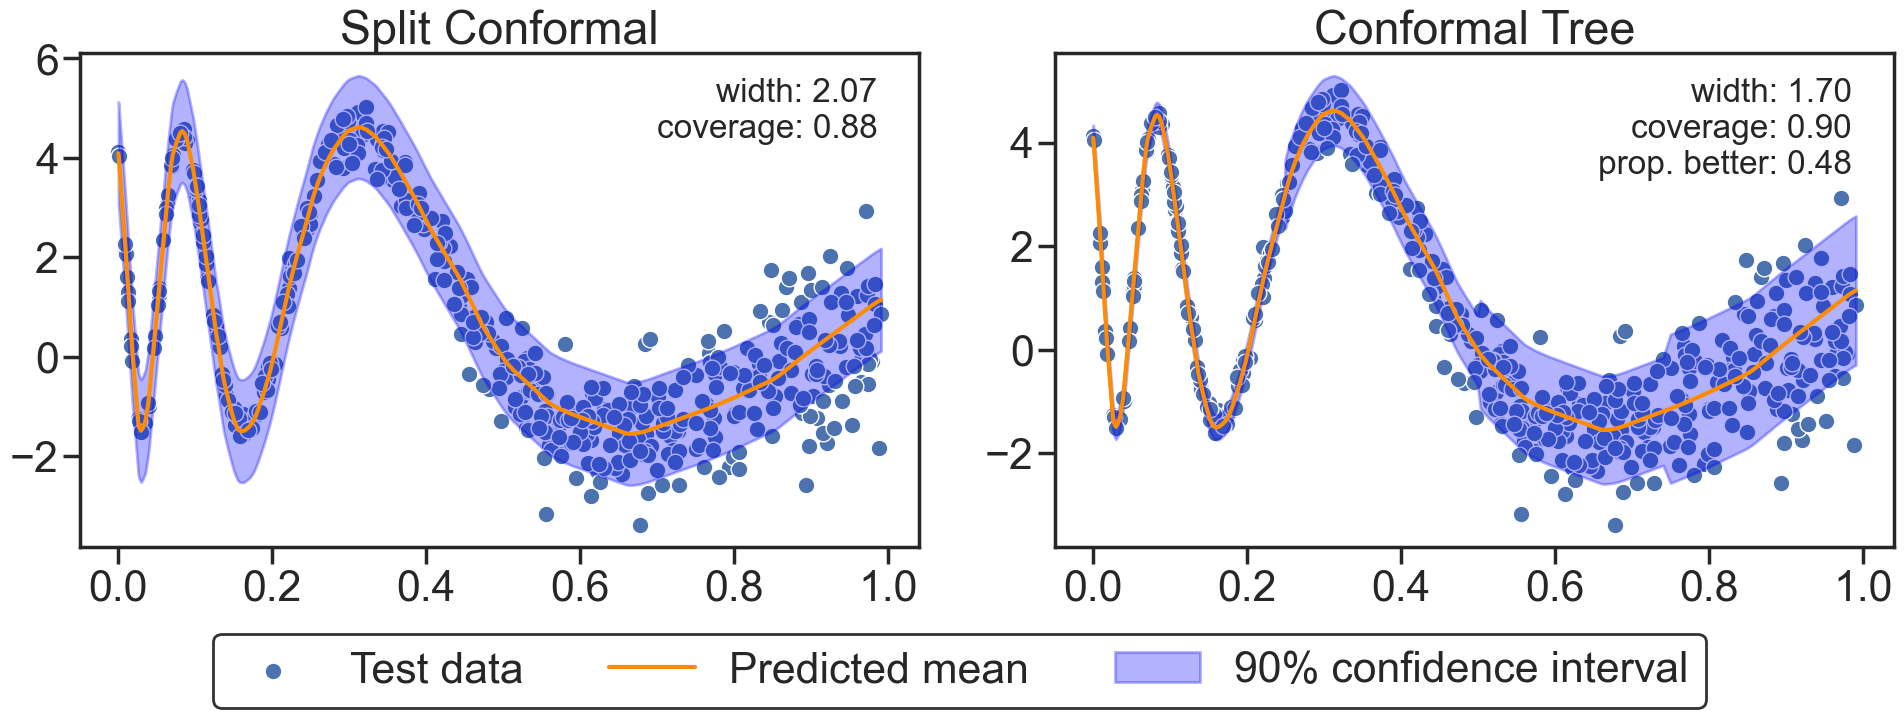

In [4]:
ctr1 = ConformalTreeRegression(domain = np.array([[0.,1.]]), min_samples_leaf=100)
scores1 = np.abs(y_calib1 - y_calib_pred1)
ctr1.calibrate(X_calib1, scores1, alpha=0.1)
lb1, ub1 = ctr1.test_set(X_test1, y_test_pred1)

lb_sc1, ub_sc1 = split_conformal(y_calib1, y_calib_pred1, y_test_pred1, alpha=0.1)


cov_tree_1 = np.mean((y_test1 > lb1)&(y_test1 < ub1))
cov_sc_1 = np.mean((y_test1 > lb_sc1)&(y_test1 < ub_sc1))

width_tree_1 = np.mean(ub1 - lb1)
width_sc_1 = np.mean(ub_sc1 - lb_sc1)

pb_1 = np.mean((ub1-lb1)<=(ub_sc1-lb_sc1))

fig, axes = plt.subplots(1,2,figsize=(20,7), sharex=True, sharey=False)

idx1 = np.argsort(X_test1.flatten())

sns.scatterplot(x=X_test1.flatten(), y=y_test1.flatten(), ax=axes[0])
sns.lineplot(x=X_test1[idx1].flatten(), y=y_test_pred1[idx1], ax=axes[0], color="darkorange")
axes[0].fill_between(X_test1.flatten()[idx1], lb_sc1[idx1], ub_sc1[idx1], color='blue', alpha=0.3)

sns.scatterplot(x=X_test1.flatten(), y=y_test1.flatten(), ax=axes[1], label="Test data", legend=False)
sns.lineplot(x=X_test1[idx1].flatten(), y=y_test_pred1[idx1], ax=axes[1], color="darkorange", label="Predicted mean", legend=False)
axes[1].fill_between(X_test1.flatten()[idx1], lb1[idx1], ub1[idx1], color='blue', alpha=0.3, label=r"90% confidence interval")


axes[0].set_title("Split Conformal")
axes[1].set_title("Conformal Tree")

axes[0].annotate(f"width: {width_sc_1:.2f}\ncoverage: {cov_sc_1:.2f}",
                   xy=(0.95, 0.95), xycoords='axes fraction',
                   fontsize=24, ha='right', va='top',
                   bbox=dict(facecolor='white', edgecolor='white'))

axes[1].annotate(f"width: {width_tree_1:.2f}\ncoverage: {cov_tree_1:.2f}\nprop. better: {pb_1:.2f}",
                   xy=(0.95, 0.95), xycoords='axes fraction',
                   fontsize=24, ha='right', va='top',
                   bbox=dict(facecolor='white', edgecolor='white'))

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), edgecolor="black")
fig.tight_layout()

plt.show()


We repeat this process for a second univariate regression dataset below

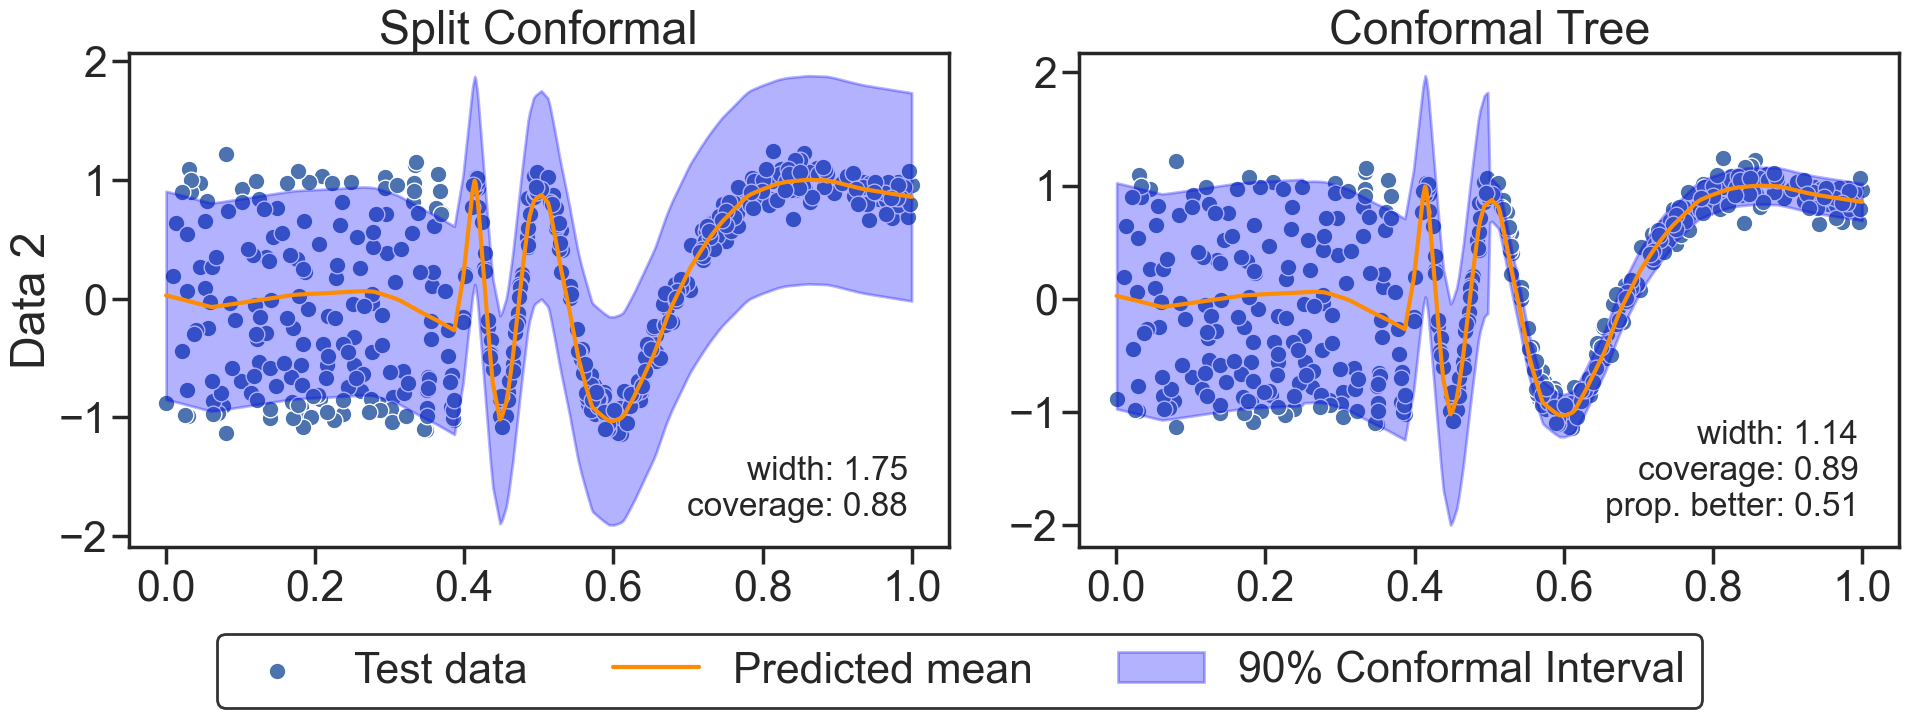

In [5]:
X_train2, y_train2, X_calib2, y_calib2, X_test2, y_test2 = gen_sin_data(data=2, n_train=2000, n_calib=500, n_test=500)

model2 = MLPRegressor(hidden_layer_sizes=(64,128,256, 256), max_iter=1000)
model2.fit(X_train2, y_train2)
y_calib_pred2 = model2.predict(X_calib2)
y_test_pred2 = model2.predict(X_test2)

ctr2 = ConformalTreeRegression(domain = np.array([[0.,1.]]), min_samples_leaf=100)
scores2 = np.abs(y_calib2 - y_calib_pred2)
ctr2.calibrate(X_calib2, scores2, alpha=0.1)
lb2, ub2 = ctr2.test_set(X_test2, y_test_pred2)

lb_sc2, ub_sc2 = split_conformal(y_calib2, y_calib_pred2, y_test_pred2, alpha=0.1)


cov_tree_2 = np.mean((y_test2 > lb2)&(y_test2 < ub2))
cov_sc_2 = np.mean((y_test2 > lb_sc2)&(y_test2 < ub_sc2))

width_tree_2 = np.mean(ub2 - lb2)
width_sc_2 = np.mean(ub_sc2 - lb_sc2)

pb_2 = np.mean((ub2-lb2)<=(ub_sc2-lb_sc2))


fig, axes = plt.subplots(1,2,figsize=(20,7), sharex=True, sharey=False)

idx2 = np.argsort(X_test2.flatten())

sns.scatterplot(x=X_test2.flatten(), y=y_test2.flatten(), ax=axes[0])
sns.lineplot(x=X_test2[idx2].flatten(), y=y_test_pred2[idx2], ax=axes[0], color="darkorange")
axes[0].fill_between(X_test2.flatten()[idx2], lb_sc2[idx2], ub_sc2[idx2], color='blue', alpha=0.3)


sns.scatterplot(x=X_test2.flatten(), y=y_test2.flatten(), ax=axes[1], label="Test data", legend=False)
sns.lineplot(x=X_test2[idx2].flatten(), y=y_test_pred2[idx2], ax=axes[1], color="darkorange", label="Predicted mean", legend=False)
axes[1].fill_between(X_test2.flatten()[idx2], lb2[idx2], ub2[idx2], color='blue', alpha=0.3, label="90% Conformal Interval")

axes[0].set_ylabel("Data 2")

axes[0].set_title("Split Conformal")
axes[1].set_title("Conformal Tree")


axes[0].annotate(f"width: {width_sc_2:.2f}\ncoverage: {cov_sc_2:.2f}",
                   xy=(0.95, 0.05), xycoords='axes fraction',
                   fontsize=24, ha='right', va='bottom',
                   bbox=dict(facecolor='white', edgecolor='white'))

axes[1].annotate(f"width: {width_tree_2:.2f}\ncoverage: {cov_tree_2:.2f}\nprop. better: {pb_2:.2f}",
                   xy=(0.95, 0.05), xycoords='axes fraction',
                   fontsize=24, ha='right', va='bottom',
                   bbox=dict(facecolor='white', edgecolor='white'))

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), edgecolor="black")
fig.tight_layout()

plt.show()



# Figure 1

Finally, we plot these together, as in Figure 1.

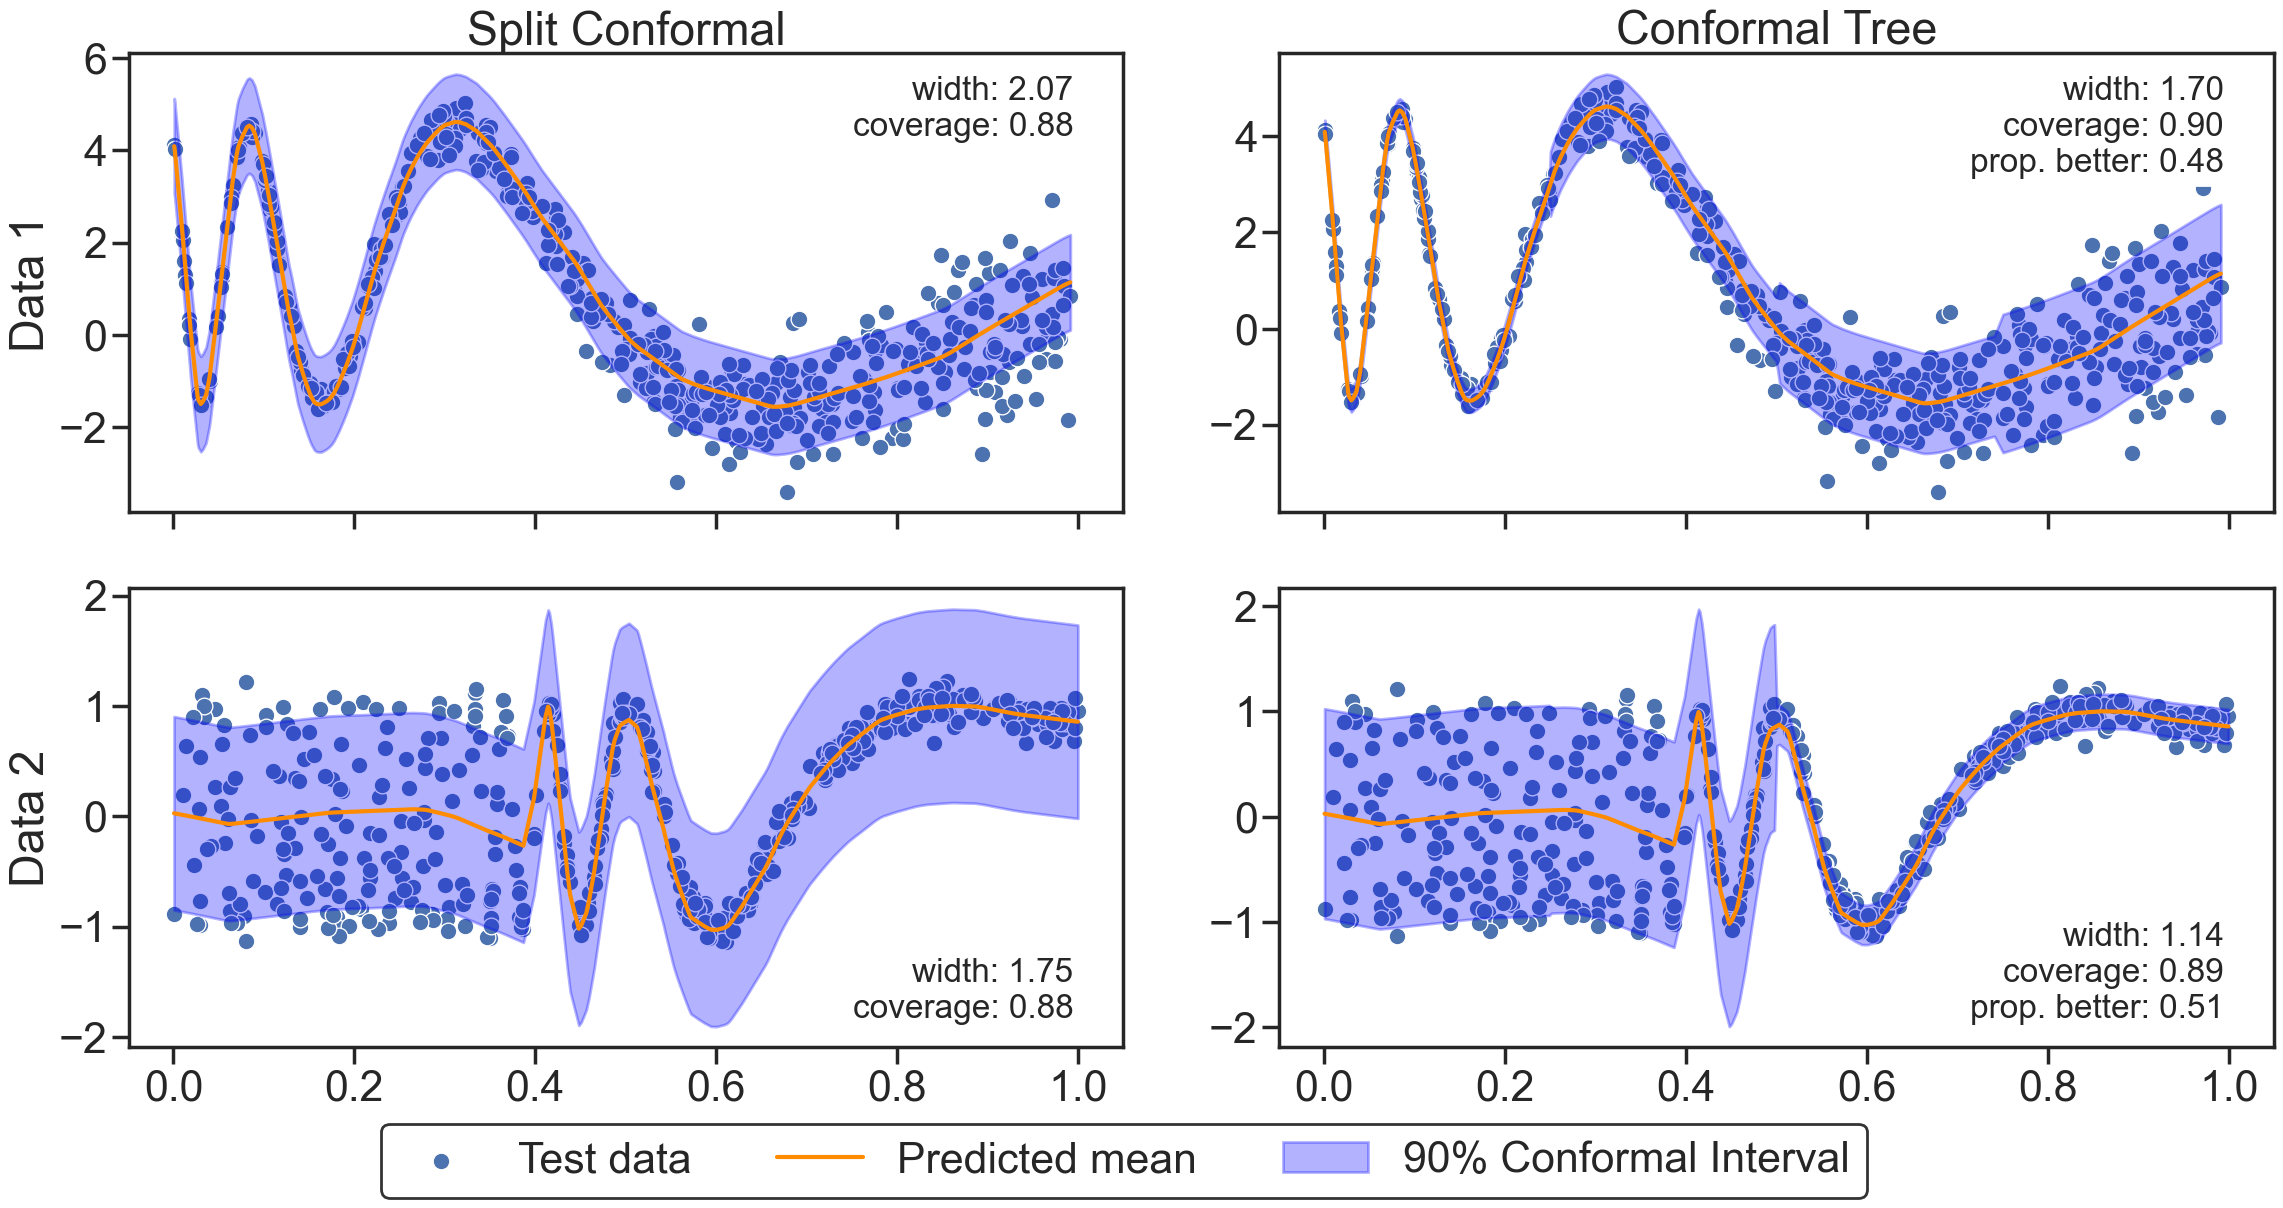

In [6]:
fig, axes = plt.subplots(2,2,figsize=(24,12), sharex=True, sharey=False)

sns.scatterplot(x=X_test1.flatten(), y=y_test1.flatten(), ax=axes[0,0])
sns.lineplot(x=X_test1[idx1].flatten(), y=y_test_pred1[idx1], ax=axes[0,0], color="darkorange")
axes[0,0].fill_between(X_test1.flatten()[idx1], lb_sc1[idx1], ub_sc1[idx1], color='blue', alpha=0.3)

sns.scatterplot(x=X_test1.flatten(), y=y_test1.flatten(), ax=axes[0,1])
sns.lineplot(x=X_test1[idx1].flatten(), y=y_test_pred1[idx1], ax=axes[0,1], color="darkorange")
axes[0,1].fill_between(X_test1.flatten()[idx1], lb1[idx1], ub1[idx1], color='blue', alpha=0.3)

sns.scatterplot(x=X_test2.flatten(), y=y_test2.flatten(), ax=axes[1,0])
sns.lineplot(x=X_test2[idx2].flatten(), y=y_test_pred2[idx2], ax=axes[1,0], color="darkorange")
axes[1,0].fill_between(X_test2.flatten()[idx2], lb_sc2[idx2], ub_sc2[idx2], color='blue', alpha=0.3)

sns.scatterplot(x=X_test2.flatten(), y=y_test2.flatten(), ax=axes[1,1], label="Test data", legend=False)
sns.lineplot(x=X_test2[idx2].flatten(), y=y_test_pred2[idx2], ax=axes[1,1], color="darkorange", label="Predicted mean", legend=False)
axes[1,1].fill_between(X_test2.flatten()[idx2], lb2[idx2], ub2[idx2], color='blue', alpha=0.3, label="90% Conformal Interval")

axes[0,0].set_ylabel("Data 1")
axes[1,0].set_ylabel("Data 2")

axes[0,0].set_title("Split Conformal")
axes[0,1].set_title("Conformal Tree")

axes[0,0].annotate(f"width: {width_sc_1:.2f}\ncoverage: {cov_sc_1:.2f}",
                   xy=(0.95, 0.95), xycoords='axes fraction',
                   fontsize=24, ha='right', va='top',
                   bbox=dict(facecolor='white', edgecolor='white'))

axes[0,1].annotate(f"width: {width_tree_1:.2f}\ncoverage: {cov_tree_1:.2f}\nprop. better: {pb_1:.2f}",
                   xy=(0.95, 0.95), xycoords='axes fraction',
                   fontsize=24, ha='right', va='top',
                   bbox=dict(facecolor='white', edgecolor='white'))

axes[1,0].annotate(f"width: {width_sc_2:.2f}\ncoverage: {cov_sc_2:.2f}",
                   xy=(0.95, 0.05), xycoords='axes fraction',
                   fontsize=24, ha='right', va='bottom',
                   bbox=dict(facecolor='white', edgecolor='white'))

axes[1,1].annotate(f"width: {width_tree_2:.2f}\ncoverage: {cov_tree_2:.2f}\nprop. better: {pb_2:.2f}",
                   xy=(0.95, 0.05), xycoords='axes fraction',
                   fontsize=24, ha='right', va='bottom',
                   bbox=dict(facecolor='white', edgecolor='white'))

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), edgecolor="black")
fig.tight_layout()

plt.show()

